# Quantum Timeseries Analysis of GOOG

In [37]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For quantum ML
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# For data loading
from torch.utils.data import Dataset, DataLoader

## Data Preparation

         Date      Open      High       Low     Close  Adj Close     Volume
0  2004-08-19  2.490664  2.591785  2.390042  2.499133   2.499133  897427216
1  2004-08-20  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
2  2004-08-23  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
3  2004-08-24  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
4  2004-08-25  2.614201  2.689918  2.587302  2.640104   2.640104  184645512
(4858, 7)


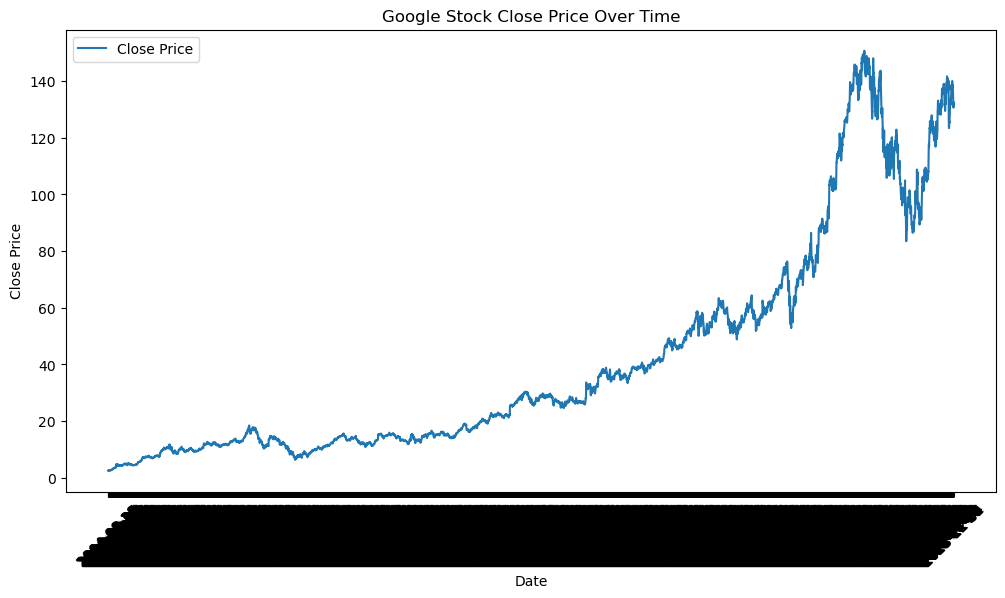

In [26]:
# Load GOOG data
df = pd.read_csv("data/GOOG stock prices since 08_19_2024.csv")

# Quick check
print(df.head())
print(df.shape)

# Plot raw close
plt.figure(figsize=(12,6))
plt.plot(df['Date'].values, df['Close'].values, label='Close Price')
plt.title("Google Stock Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Sliding Window Preparation

In [27]:
def create_sliding_window(df, window_size=5):
    """
    df must have columns: 'Date', 'Close'.
    Returns:
      X: shape (N, window_size)
      y: shape (N,)
      dates: array of length N indicating the date corresponding to y
    """
    close_arr = df['Close'].values
    date_arr = df['Date'].values
    
    X, y, dates = [], [], []
    for i in range(len(df) - window_size):
        X_window = close_arr[i : i + window_size]
        y_val = close_arr[i + window_size]
        date_val = date_arr[i + window_size]
        
        X.append(X_window)
        y.append(y_val)
        dates.append(date_val)
    
    return np.array(X), np.array(y), np.array(dates)

# Example usage
window_size = 5
X_all, y_all, date_all = create_sliding_window(df, window_size=window_size)
print("Shape of X_all:", X_all.shape, "y_all:", y_all.shape)

Shape of X_all: (4853, 5) y_all: (4853,)


## Train/Test Split; Scale Inputs

In [28]:
split_date = '2023-01-01'
mask_train = date_all < split_date
mask_test = date_all >= split_date

X_train = X_all[mask_train]
y_train = y_all[mask_train]
dates_train = date_all[mask_train]

X_test = X_all[mask_test]
y_test = y_all[mask_test]
dates_test = date_all[mask_test]

print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Train set size: (4620, 5) (4620,)
Test set size: (233, 5) (233,)


In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))
# Flatten (N, window_size) to 2D
X_train_2d = X_train.reshape(-1, window_size)
X_test_2d = X_test.reshape(-1, window_size)

scaler.fit(X_train_2d)
X_train_scaled = scaler.transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

# reshape back
X_train = X_train_scaled.reshape(-1, window_size)
X_test = X_test_scaled.reshape(-1, window_size)

## Set up Quantum Regression Network

In [38]:
def create_regression_qnn(input_dim=5, n_qubits=2, n_layers=2):
    data_params = ParameterVector("x", length=input_dim)
    theta_params = ParameterVector("θ", length=n_layers * 2 * n_qubits)

    qc = QuantumCircuit(n_qubits)

    # -- Data encoding (use each of the 5 features) --
    for i in range(input_dim):
        # pick a qubit (for example i % n_qubits) 
        qubit_idx = i % n_qubits
        qc.rx(data_params[i], qubit_idx)
        qc.rz(data_params[i], qubit_idx)

    # -- Variational layers --
    param_idx = 0
    for layer in range(n_layers):
        for q in range(n_qubits):
            qc.ry(theta_params[param_idx], q)
            qc.rz(theta_params[param_idx+1], q)
            param_idx += 2

        # entangle in a chain
        for q in range(n_qubits-1):
            qc.cx(q, q+1)

    # We now have exactly 5 references to data_params + 8 references to theta_params = 13 total

    # measurement operator:
    observable = [SparsePauliOp.from_list([("Z" + "I"*(n_qubits-1), 1.0)])]

    estimator = Estimator()
    qnn = EstimatorQNN(
        circuit=qc,
        observables=observable,
        input_params=list(data_params),
        weight_params=list(theta_params),
        estimator=estimator,
    )
    
    # wrap with TorchConnector + a small post-processing layer
    qnn_torch = TorchConnector(qnn)

    class HybridRegressor(nn.Module):
        def __init__(self):
            super().__init__()
            self.qnn = qnn_torch
            self.linear = nn.Linear(1, 1)  # map [-1,1] => real

        def forward(self, x):
            q_out = self.qnn(x)          # => (batch_size, 1)
            return self.linear(q_out).squeeze()

    return HybridRegressor()

## Pytorch Dataset/DataLoader

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Train QNN

In [40]:
model = create_regression_qnn(input_dim=window_size, n_qubits=2, n_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

/tmp/ipykernel_5809/1921783530.py:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


KeyboardInterrupt: 

## Rolling Forecase on Test Set

In [33]:
model.eval()

preds_list = []
actual_list = []

with torch.no_grad():
    for i in range(len(X_test)):
        x_input = torch.tensor(X_test[i], dtype=torch.float32).unsqueeze(0).to(device)
        pred_val = model(x_input).item()
        preds_list.append(pred_val)
        actual_list.append(y_test[i])

preds_list = np.array(preds_list)
actual_list = np.array(actual_list)
dates_test_list = dates_test

NameError: name 'model' is not defined

## Evaluate

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actual_list, preds_list)
print("Test MSE:", mse)

plt.figure(figsize=(12,6))
plt.plot(dates_test_list, actual_list, label='Actual', color='black')
plt.plot(dates_test_list, preds_list, label='Predicted', color='red')
plt.xticks(rotation=45)
plt.title("QNN Rolling Forecast (Single Training)")
plt.legend()
plt.show()

Rolling Recursive MSE: 5.172309332622631
